# 贝叶斯抠图

In [1]:
#coding:utf-8
import numpy as np
%matplotlib  inline
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from scipy.misc import imread, imresize, imsave
from skimage.filters import threshold_otsu
from skimage.color import rgb2lab
import scipy.spatial.distance
import scipy.signal
import skimage
import skimage.io
from skimage.segmentation import slic
from skimage.util import img_as_float
from scipy.optimize import minimize
import math
import operator
import networkx as nx
import pdb
import itertools
from scipy.ndimage.filters import gaussian_filter
from numba import jit 

In [2]:
# Implementation of orchard bouman clustering
# Not the cleanest code
# Might be faster if rewritten in all numpy, node object -> array
# May be able to be spedup with numba. 

class Node(object):

    def __init__(self, matrix, w):
        W = np.sum(w)
        self.w = w
        self.X = matrix
        self.left = None
        self.right = None
        self.mu = np.einsum('ij,i->j', self.X, w)/W
        diff = self.X - np.tile(self.mu, [np.shape(self.X)[0], 1])
        t = np.einsum('ij,i->ij', diff, np.sqrt(w))
        self.cov = (t.T @ t)/W + 1e-5*np.eye(3)
        self.N = self.X.shape[0]
        V, D = np.linalg.eig(self.cov)
        self.lmbda = np.max(np.abs(V))
        self.e = D[np.argmax(np.abs(V))]


# S is measurements vector - dim nxd
# w is weights vector - dim n
def clustFunc(S, w, minVar=0.05):
    mu, sigma = [], []
    nodes = []
    nodes.append(Node(S, w))

    while max(nodes, key=lambda x: x.lmbda).lmbda > minVar:
        nodes = split(nodes)

    for i, node in enumerate(nodes):
        mu.append(node.mu)
        sigma.append(node.cov)

    return np.array(mu), np.array(sigma)


def split(nodes):
    idx_max = max(enumerate(nodes), key=lambda x: x[1].lmbda)[0]
    C_i = nodes[idx_max]
    idx = C_i.X @ C_i.e <= np.dot(C_i.mu, C_i.e)
    C_a = Node(C_i.X[idx], C_i.w[idx])
    C_b = Node(C_i.X[np.logical_not(idx)], C_i.w[np.logical_not(idx)])
    nodes.pop(idx_max)
    nodes.append(C_a)
    nodes.append(C_b)
    return nodes

In [6]:
def matlab_style_gauss2d(shape=(3, 3), sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m, n = [(ss-1.)/2. for ss in shape]
    y, x = np.ogrid[-m:m+1, -n:n+1]
    h = np.exp(-(x*x + y*y)/(2.*sigma*sigma))
    h[h < np.finfo(h.dtype).eps*h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h


# returns the surrounding N-rectangular neighborhood of matrix m, centered
# at pixel (x,y), (odd valued N)
@jit(nopython=True, cache=True)
def get_window(m, x, y, N):
    h, w, c = m.shape
    halfN = N//2
    r = np.zeros((N, N, c))
    xmin = max(0, x - halfN); xmax = min(w, x + (halfN+1))
    ymin = max(0, y - halfN); ymax = min(h, y + (halfN+1))
    pxmin = halfN - (x-xmin); pxmax = halfN + (xmax-x)
    pymin = halfN - (y-ymin); pymax = halfN + (ymax-y)

    r[pymin:pymax, pxmin:pxmax] = m[ymin:ymax, xmin:xmax]
    return r

@jit(nopython=True, cache=True)
def solve(mu_F, Sigma_F, mu_B, Sigma_B, C, sigma_C, alpha_init, maxIter, minLike):
    '''
    Solves for F,B and alpha that maximize the sum of log
    likelihoods at the given pixel C.
    input:
    mu_F - means of foreground clusters (for RGB, of size 3x#Fclusters)
    Sigma_F - covariances of foreground clusters (for RGB, of size
    3x3x#Fclusters)
    mu_B,Sigma_B - same for background clusters
    C - observed pixel
    alpha_init - initial value for alpha
    maxIter - maximal number of iterations
    minLike - minimal change in likelihood between consecutive iterations
    returns:
    F,B,alpha - estimate of foreground, background and alpha
    channel (for RGB, each of size 3x1)
    '''
    I = np.eye(3)
    FMax = np.zeros(3)
    BMax = np.zeros(3)
    alphaMax = 0
    maxlike = - np.inf
    invsgma2 = 1/sigma_C**2
    for i in range(mu_F.shape[0]):
        mu_Fi = mu_F[i]
        invSigma_Fi = np.linalg.inv(Sigma_F[i])
        for j in range(mu_B.shape[0]):
            mu_Bj = mu_B[j]
            invSigma_Bj = np.linalg.inv(Sigma_B[j])

            alpha = alpha_init
            myiter = 1
            lastLike = -1.7977e+308
            while True:
                # solve for F,B
                A11 = invSigma_Fi + I*alpha**2 * invsgma2
                A12 = I*alpha*(1-alpha) * invsgma2
                A22 = invSigma_Bj+I*(1-alpha)**2 * invsgma2
                A = np.vstack((np.hstack((A11, A12)), np.hstack((A12, A22))))
                b1 = invSigma_Fi @ mu_Fi + C*(alpha) * invsgma2
                b2 = invSigma_Bj @ mu_Bj + C*(1-alpha) * invsgma2
                b = np.atleast_2d(np.concatenate((b1, b2))).T

                X = np.linalg.solve(A, b)
                F = np.maximum(0, np.minimum(1, X[0:3]))
                B = np.maximum(0, np.minimum(1, X[3:6]))
                # solve for alpha

                alpha = np.maximum(0, np.minimum(1, ((np.atleast_2d(C).T-B).T @ (F-B))/np.sum((F-B)**2)))[0,0]
                # # calculate likelihood
                L_C = - np.sum((np.atleast_2d(C).T -alpha*F-(1-alpha)*B)**2) * invsgma2
                L_F = (- ((F- np.atleast_2d(mu_Fi).T).T @ invSigma_Fi @ (F-np.atleast_2d(mu_Fi).T))/2)[0,0]
                L_B = (- ((B- np.atleast_2d(mu_Bj).T).T @ invSigma_Bj @ (B-np.atleast_2d(mu_Bj).T))/2)[0,0]
                like = (L_C + L_F + L_B)
                #like = 0

                if like > maxlike:
                    alphaMax = alpha
                    maxLike = like
                    FMax = F.ravel()
                    BMax = B.ravel()

                if myiter >= maxIter or abs(like-lastLike) <= minLike:
                    break

                lastLike = like
                myiter += 1
    return FMax, BMax, alphaMax


def bayesian_matte(img, trimap, sigma=8, N=25, minN=10):
    img = img/255

    h, w, c = img.shape
    alpha = np.zeros((h, w))

    fg_mask = trimap == 255
    bg_mask = trimap == 0
    unknown_mask = True ^ np.logical_or(fg_mask, bg_mask)
    foreground = img*np.repeat(fg_mask[:, :, np.newaxis], 3, axis=2)
    background = img*np.repeat(bg_mask[:, :, np.newaxis], 3, axis=2)

    gaussian_weights = matlab_style_gauss2d((N, N), sigma)
    gaussian_weights = gaussian_weights/np.max(gaussian_weights)

    alpha[fg_mask] = 1
    F = np.zeros(img.shape)
    B = np.zeros(img.shape)
    alphaRes = np.zeros(trimap.shape)

    n = 1
    alpha[unknown_mask] = np.nan
    nUnknown = np.sum(unknown_mask)
    unkreg = unknown_mask

    kernel = np.ones((3, 3))
    while n < nUnknown:
        unkreg = cv2.erode(unkreg.astype(np.uint8), kernel, iterations=1)
        unkpixels = np.logical_and(np.logical_not(unkreg), unknown_mask)

        Y, X = np.nonzero(unkpixels)

        for i in range(Y.shape[0]):
#             if n % 100 == 0:
#                # print(n, nUnknown)
            y, x = Y[i], X[i]
            p = img[y, x]
            # Try cluster Fg, Bg in p's known neighborhood

            # take surrounding alpha values
            a = get_window(alpha[:, :, np.newaxis], x, y, N)[:, :, 0]

            # Take surrounding foreground pixels
            f_pixels = get_window(foreground, x, y, N)
            f_weights = (a**2 * gaussian_weights).ravel()

            f_pixels = np.reshape(f_pixels, (N*N, 3))
            posInds = np.nan_to_num(f_weights) > 0
            f_pixels = f_pixels[posInds, :]
            f_weights = f_weights[posInds]

            # Take surrounding foreground pixels
            b_pixels = get_window(background, x, y, N)
            b_weights = ((1-a)**2 * gaussian_weights).ravel()

            b_pixels = np.reshape(b_pixels, (N*N, 3))
            posInds = np.nan_to_num(b_weights) > 0
            b_pixels = b_pixels[posInds, :]
            b_weights = b_weights[posInds]

            # if not enough data, return to it later...
            if len(f_weights) < minN or len(b_weights) < minN:
                continue
            # Partition foreground and background pixels to clusters (in a weighted manner)
            mu_f, sigma_f = clustFunc(f_pixels, f_weights)
            mu_b, sigma_b = clustFunc(b_pixels, b_weights)

            alpha_init = np.nanmean(a.ravel())
            # Solve for F,B for all cluster pairs
            f, b, alphaT = solve(mu_f, sigma_f, mu_b, sigma_b, p, 0.01, alpha_init, 50, 1e-6)
            foreground[y, x] = f.ravel()
            background[y, x] = b.ravel()
            alpha[y, x] = alphaT
            unknown_mask[y, x] = 0
            n += 1

    return alpha

In [7]:
img = scipy.misc.imread("../datas/troll.png")[:, :, :3]
trimap = scipy.misc.imread("../datas/trollTrimap.bmp", flatten='True')
alpha = bayesian_matte(img, trimap)

C:\Users\jenson\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
C:\Users\jenson\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


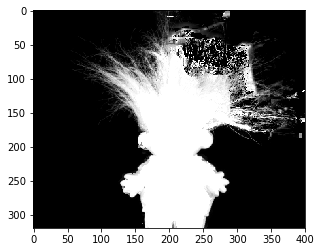

In [10]:
plt.imshow(alpha,'gray')

In [12]:
print(alpha)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


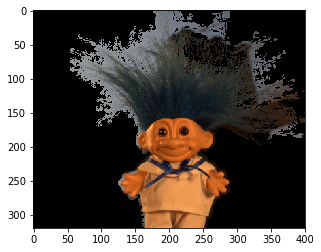

In [17]:
dst_match = np.zeros_like(img)
idx = (alpha > 0)
dst_match[idx] = img[idx]
plt.imshow(dst_match)

参考：

[1].https://github.com/MarcoForte/bayesian-matting
    
[2].https://blog.csdn.net/baimafujinji/article/details/72863106